In [1]:
# calculate the linear regression for each gridpoint and mean over the areas from the mask function
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
# import xclim as xc
import os
from matplotlib import rcParams
from memory_profiler import profile
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import pandas as pd
from matplotlib import rcParams
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import os
from memory_profiler import profile
import scipy.stats as stats
import scipy.signal as signal
import Calculation.mask_creation as mc

# from cartopy.mpl.geoaxes import GeoAxes
# GeoAxes._pcolormesh_patched = Axes.pcolormesh

homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"
populationfolder = plotfolder + "Population/"


plt.rcParams.update(plotfunc.rcParams_area)
plt.rcParams.update({'hatch.linewidth': 2})
plt.rcParams.update({'figure.titlesize': 17,
                'axes.titlesize': 17,
                'axes.labelsize': 17,
                'xtick.labelsize': 13,
                'ytick.labelsize': 13,})

import scipy.ndimage as ndimage
filter_func = lambda y : ndimage.gaussian_filter(y, sigma=2.0, truncate=2.0, mode='constant', cval=np.nan)
filter_name = "gauss"

In [2]:
# load data
data = xr.open_dataset(datafolder + '/New2_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

regions = [("EUR", None),('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19) ]


In [3]:
# import cartopy

min_yearlydays = 3
quantile_sWBGT = 0.98
min_years = 5
min_years_low = 2
title_first30 = "a) 1900-1930 people exposed"
title_last30 = "b) 1980-2010 people exposed"
middle_title = "c) total population exposed"
lower_title = "d) percentile of regional population exposed"
suptitle = "population exposed to heatwave\nat least {:.0f} heatwave days per year and {:.0f} percentile of sWBGT\nfor a) and b) if at least {:.0f} years with above conditions occure\n for a) and b) hatched if at least {:.0f} years with above conditions occure".format(min_yearlydays, quantile_sWBGT * 100, min_years, min_years_low)
savename = "population_exposed_{:.0f}mindays_{:.0f}percsWBGT_{:.0f}years".format(min_yearlydays, quantile_sWBGT * 100, min_years)

mask_org = data.heatwave_mask_ydrunpctl_98_referenceperiod & (data.swbgt >= data.swbgt.quantile(quantile_sWBGT, dim = 'time'))
mask = (mask_org.groupby("time.year").sum('time')) >= min_yearlydays
# print(mask)

xmin = 1899
xmax = 2011

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


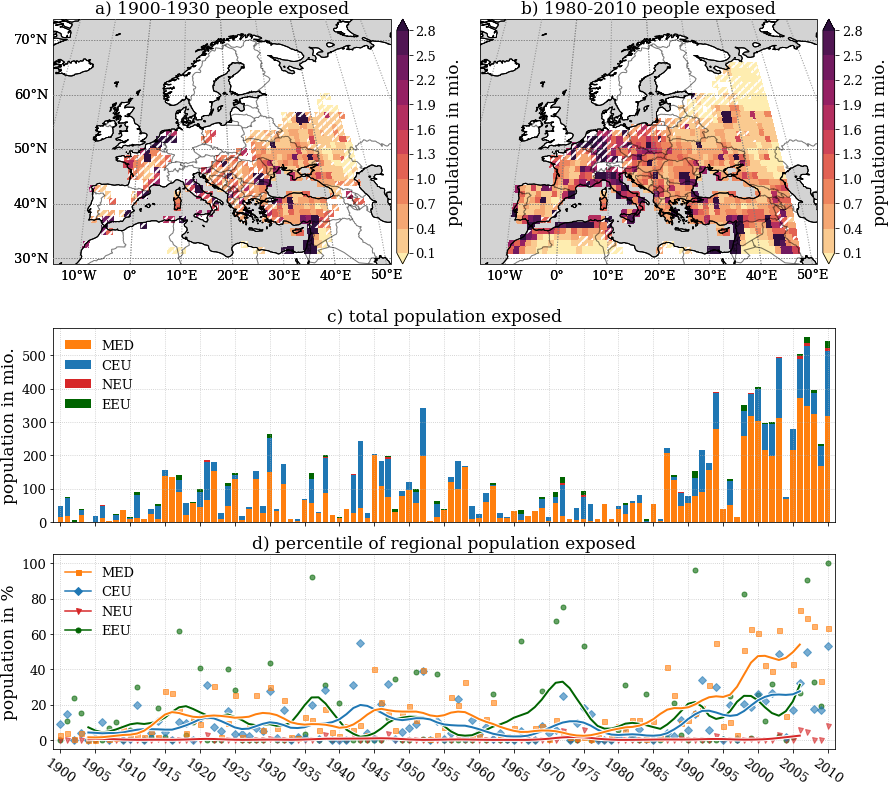

In [4]:
fig = plt.figure(figsize = (14,14))
gs = gridspec.GridSpec(7,2, wspace = 0.2 , hspace = 0.4)
# plt.suptitle(suptitle, y = 0.94)

# first 30 years
timeslice = slice('1900','1931')
plot_data_low = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years_low)
plot_data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years)

ax0 = fig.add_subplot(gs[0:3, 0],\
    projection=ccrs.EckertV(central_longitude=12.5))
plotfunc.area_plot(pcolormesh = False,  pcolor = True, ax = ax0, data = plot_data_low, 
                   cmap = 'cmo.matter',levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(add_colorbar = False, extend = "both"), 
                   pcolormesh_kwargs = dict(alpha = 1, hatch= '///'))
plotfunc.area_plot(ax = ax0, data = plot_data, 
                   cmap = 'cmo.matter', levels = np.arange(0.1,3,0.3), 
                   colorbar_kwargs = dict(label = "populationn in mio.", extend = "both"),
                   landcolor= False)
ax0.set_title(title_first30)

# last 30 years
timeslice = slice('1980','2010')
plot_data_low = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years_low)
plot_data = (data.population_total*1e-6).where(mask.sel(year = timeslice).sum("year") >= min_years)

ax1 = fig.add_subplot(gs[0:3, 1],\
    projection=ccrs.EckertV(central_longitude=12.5))
plotfunc.area_plot(pcolormesh = False,  pcolor = True, ax = ax1, data = plot_data_low, 
                   cmap = 'cmo.matter',levels = np.arange(0.1,3,0.3), 
                   gridline_kwargs = dict(left_labels = False),
                   colorbar_kwargs = dict(add_colorbar = False, extend = "both"), 
                   pcolormesh_kwargs = dict(alpha = 1, hatch= '///'))
plotfunc.area_plot(ax = ax1, data = plot_data, 
                   cmap = 'cmo.matter', levels = np.arange(0.1,3,0.3), 
                   gridline_kwargs = dict(left_labels = False),
                   colorbar_kwargs = dict(label = "populationn in mio.", extend = "both", ),
                   landcolor= False)
# ax.add_feature(cartopy.feature.BORDERS, zorder = 10, color = "k", alpha = 0.5)
ax1.set_title(title_last30)


ax2 = fig.add_subplot(gs[3:5,:])
bottom = 0
for idx, color, name in [(19, 'tab:orange', 'MED'), (17,'tab:blue', 'CEU'), (16, 'tab:red', 'NEU'), (18, 'darkgreen', 'EEU')]:
    plot_data = (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})#/((data.population_total*1e-6).where(mc.mask_region(data.population_total, 16)).sum({'latitude','longitude'}))
    ax2.bar(mask.year, plot_data, bottom = bottom, facecolor = color, label = name)
    bottom += plot_data
# idx, color, name = (None, 'k', 'EUR')
# plot_data = (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})

# ax2.plot(mask.year, filter_func(plot_data), color = color, linestyle = '--')
ax2.legend()
ax2.set_title(middle_title)
ax2.set_ylabel('population in mio.')
ax2.set_xlim([xmin,xmax])
ax2.set_xticks(np.arange(xmin +1,xmax,5))
ax2.grid()


ax3 = fig.add_subplot(gs[5:,:])
patches = []
for idx, color, name, marker in [(18, 'darkgreen', 'EEU', 'o'), (16, 'tab:red', 'NEU', 'v'), (17,'tab:blue', 'CEU', 'D'), (19, 'tab:orange', 'MED', 's')]:
    plot_data = 100 * (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})/((data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'}))
    ax3.plot(mask.year, filter_func(plot_data), color = 'w', linewidth = 4, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, filter_func(plot_data), color = color, linewidth = 2, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, plot_data, color = color, linestyle = '-', linewidth = 0, markersize = 5, marker = marker, alpha = 0.6, zorder = 2)
    patches.append(mlines.Line2D([], [], color=color, marker=marker,
                          markersize=5, label=name))

ax3.legend(handles = patches[::-1])
ax3.set_title(lower_title)
ax3.set_ylabel('population in %')
ax3.get_shared_x_axes().join(ax2, ax3)
ax2.set_xticklabels([])
ax3.set_xticks(np.arange(xmin +1,xmax,5))
ax3.set_xticklabels(np.arange(xmin +1,xmax,5), rotation = -35)
ax3.set_xlim([xmin,xmax])

# ax3.set_xtickslabels(np.arange(xmax +1,xmax,5))
ax3.grid()
fig.savefig(populationfolder + savename + '_ydrunpctl_98_referenceperiod')

**plot area evolution**

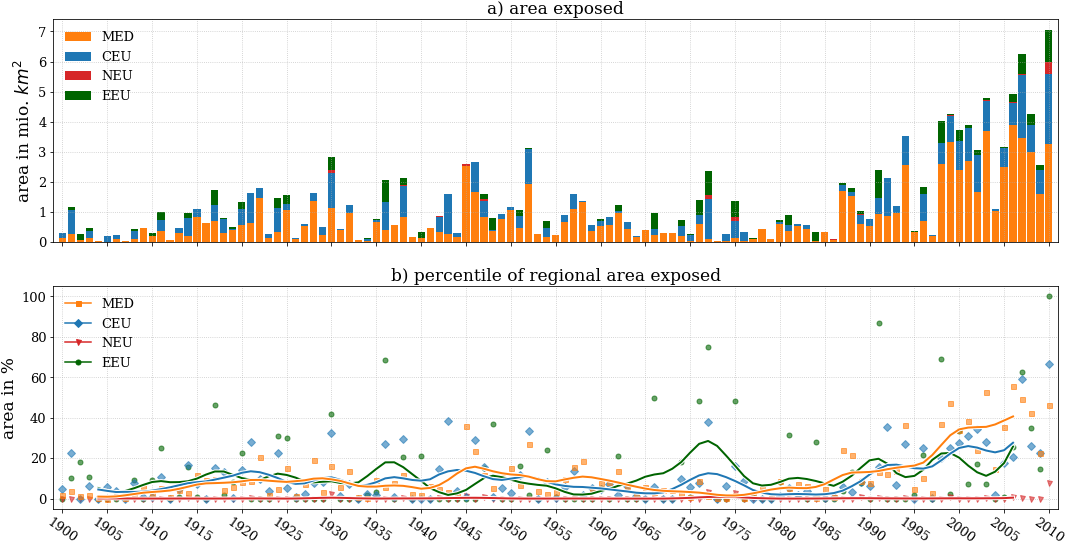

In [5]:
# import cartopy
middle_title = "a) area exposed"
lower_title = "b) percentile of regional area exposed"
savename = "area_effected_{:.0f}mindays_{:.0f}percsWBGT_{:.0f}years".format(min_yearlydays, quantile_sWBGT * 100, min_years)

mask = data.heatwave_mask_ydrunpctl_98_referenceperiod & (data.swbgt >= data.swbgt.quantile(quantile_sWBGT, dim = 'time'))
mask = (mask.groupby("time.year").sum('time')) >= min_yearlydays
# print(mask)

xmin = 1899
xmax = 2011

fig = plt.figure(figsize = (18,9))
gs = gridspec.GridSpec(2,2, hspace = 0.2)
# plt.suptitle(suptitle, y = 0.94)

ax2 = fig.add_subplot(gs[0,:])
bottom = 0
for idx, color, name in [(19, 'tab:orange', 'MED'), (17,'tab:blue', 'CEU'), (16, 'tab:red', 'NEU'), (18, 'darkgreen', 'EEU')]:
    plot_data = (mask * data.area*1e-6).where(mc.mask_region(data.area, idx)).sum({'latitude','longitude'})#/((data.population_total*1e-6).where(mc.mask_region(data.population_total, 16)).sum({'latitude','longitude'}))
    ax2.bar(mask.year, plot_data, bottom = bottom, facecolor = color, label = name)
    bottom += plot_data
# idx, color, name = (None, 'k', 'EUR')
# plot_data = (mask * data.population_total*1e-6).where(mc.mask_region(data.population_total, idx)).sum({'latitude','longitude'})

# ax2.plot(mask.year, filter_func(plot_data), color = color, linestyle = '--')
ax2.legend()
ax2.set_title(middle_title)
ax2.set_ylabel(r'area in mio. $km^2$')
ax2.set_xlim([xmin,xmax])
ax2.set_xticks(np.arange(xmin +1,xmax,5))
ax2.grid()


ax3 = fig.add_subplot(gs[1,:])
patches = []
for idx, color, name, marker in [(18, 'darkgreen', 'EEU', 'o'), (16, 'tab:red', 'NEU', 'v'), (17,'tab:blue', 'CEU', 'D'), (19, 'tab:orange', 'MED', 's')]:
    plot_data = 100 * (mask * data.area*1e-6).where(mc.mask_region(data.area, idx)).sum({'latitude','longitude'})/((data.area*1e-6).where(mc.mask_region(data.area, idx)).sum({'latitude','longitude'}))
    ax3.plot(mask.year, filter_func(plot_data), color = 'w', linewidth = 4, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, filter_func(plot_data), color = color, linewidth = 2, linestyle = '-', marker = marker, markersize = 0, label = name, zorder = 3)
    ax3.plot(mask.year, plot_data, color = color, linestyle = '-', linewidth = 0, markersize = 5, marker = marker, alpha = 0.6, zorder = 2)
    patches.append(mlines.Line2D([], [], color=color, marker=marker,
                          markersize=5, label=name))

ax3.legend(handles = patches[::-1])
ax3.set_title(lower_title)
ax3.set_ylabel('area in %')
ax3.get_shared_x_axes().join(ax2, ax3)
ax2.set_xticklabels([])
ax3.set_xticks(np.arange(xmin +1,xmax,5))
ax3.set_xticklabels(np.arange(xmin +1,xmax,5), rotation = -35)
ax3.set_xlim([xmin,xmax])

# ax3.set_xtickslabels(np.arange(xmax +1,xmax,5))
ax3.grid()
fig.savefig(populationfolder + savename + '_ydrunpctl_98_referenceperiod')